# Simulations for multi-resolution deblending

In [1]:
import scarlet
import galsim
from astropy import wcs as WCS
import time
from mr_tools import galsim_compare_tools as gct
import proxmin

# Import Packages and setup
import numpy as np
import scarlet.display
from scarlet.display import AsinhMapping
from scarlet import Starlet
from scarlet.wavelet import mad_wavelet
import scipy.stats as scs
from scarlet.initialization import build_initialization_coadd
from functools import partial
from scarlet_extensions.initialization.detection import makeCatalog, Data

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# use a better colormap and don't interpolate the pixels
matplotlib.rc('image', cmap='gist_stern')
matplotlib.rc('image', interpolation='none')

In [2]:
%pylab inline
# Setup: declaring survey properties, loading catalog and making sure we have pretty colorbars
data_dir='/Users/remy/Desktop/LSST_Project/GalSim/examples/data'

HST, EUCLID, WFIRST, HSC, RUBIN = gct.load_surveys()

center_ra = 19.3*galsim.hours     # The RA, Dec of the center of the image on the sky
center_dec = -33.1*galsim.degrees

cat = galsim.COSMOSCatalog(dir=data_dir, file_name = 'real_galaxy_catalog_23.5_example.fits')

mymap = 'gnuplot2'#mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
matplotlib.rc('image', cmap='gist_stern')
matplotlib.rc('image', interpolation='none')

Populating the interactive namespace from numpy and matplotlib


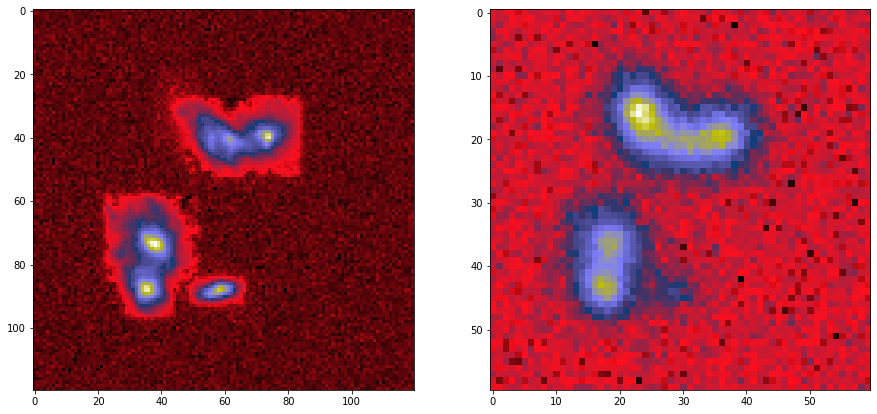

In [3]:
# Generate simulations
hr_dict = EUCLID
lr_dict = RUBIN

nlr = 60
nhr = np.int(np.around(nlr*lr_dict['pixel']/hr_dict['pixel'], decimals = 3))
mk_sim = 1
if mk_sim:
    hr, lr, wcs_hr, wcs_lr, psf_hr, psf_lr, shifts = gct.mk_scene(hr_dict, lr_dict, cat, 
                                                                  (nhr,nhr), (nlr,nlr), 7, gal_type = 'real')
    hr = hr[None, :,:]
else: 
    datas = np.load('Multires_simulation.npz', allow_pickle = True)
    hr, lr = datas['images']
    psf_hr, psf_lr = datas['psf']
    wcs_hr, wcs_lr = datas['wcs']
    wcs_hr.array_shape = wcs_hr.wcs.crpix*2
    wcs_lr.array_shape = wcs_lr.wcs.crpix*2
    shifts = np.zeros((2,4))
    
    
plt.figure(figsize = (15, 30))
plt.subplot(121)
plt.imshow(hr[0])
plt.subplot(122)
plt.imshow(lr[0])
plt.show()

In [4]:
# Channels
channels_hr = ['F814w']
channels_lr = ['g','r','i']
n,n1,n2 = np.shape(hr)

# Scale the HST data
_,n1,n2 = np.shape(hr)
# Scale the HSC data
r, N1, N2 = lr.shape

In [25]:
# Detectino of sources
data_hr =  Data(hr, wcs_hr, psf_hr, channels_hr)
data_lr =  Data(lr, wcs_lr, psf_lr, channels_lr)

datas = [data_lr, data_hr]
wave = 1
lvl = 3
#Joint detection from coadded datasets
catalog_multi, bg_rms_multi = makeCatalog([data_lr, data_hr], lvl, wave)

# Detection ran on low resolution data only .
catalog_lr, bg_rms_lr = makeCatalog(lr, lvl, wave)
# Detection ran on low resolution data only.
catalog_hr, bg_rms_hr = makeCatalog(hr, lvl, wave)

weights_hr = np.ones_like(hr) / (bg_rms_multi[1]**2)[:, None, None]
weights_lr = np.ones_like(lr) / (bg_rms_multi[0]**2)[:, None, None]

AttributeError: can't set attribute

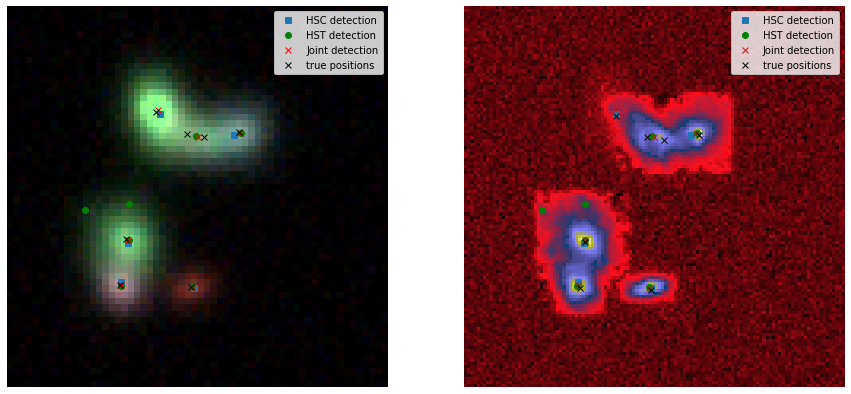

In [6]:
#Results of the detection

# Create a color mapping for the HSC image
lr_norm = AsinhMapping(minimum=0, stretch=1, Q=0.1)
hr_norm = AsinhMapping(minimum=0, stretch=1, Q=1)

# Get the source coordinates from the HST catalog
xtrue, ytrue = shifts[:,0], shifts[:,1]
xt,yt = catalog_hr['x'], catalog_hr['y'] 
xm,ym = catalog_multi['x'], catalog_multi['y']
xc,yc = catalog_lr['x'], catalog_lr['y']
# Convert the HST coordinates to the HSC WCS
ratrue, dectrue = wcs_hr.wcs_pix2world(ytrue,xtrue,1)
rat, dect = wcs_hr.wcs_pix2world(yt,xt, 0)
ram, decm = wcs_hr.wcs_pix2world(ym,xm, 0)
rac, decc = wcs_lr.wcs_pix2world(yc,xc, 0)

Ytrue, Xtrue = wcs_lr.wcs_world2pix(ratrue, dectrue,0)
Yt,Xt = np.array(wcs_lr.wcs_world2pix(rat, dect, 0))
Ym,Xm = np.array(wcs_lr.wcs_world2pix(ram, decm, 0))
Yc,Xc = np.array(wcs_hr.wcs_world2pix(rac, decc, 0))
# Map the HSC image to RGB
img_rgb = scarlet.display.img_to_rgb(lr, norm=lr_norm)
# Apply Asinh to the HST data
hr_img = scarlet.display.img_to_rgb(hr, norm=hr_norm)

plt.figure(figsize=(15,30))
plt.subplot(121)
plt.imshow(img_rgb)
plt.axis('off')
plt.plot(xc,yc, 's', label = 'HSC detection')
plt.plot(Xt,Yt, 'og', label = 'HST detection')
plt.plot(Xm,Ym, 'xr', label = 'Joint detection')
plt.plot(Xtrue,Ytrue, 'xk', label = 'true positions')
plt.legend()

plt.subplot(122)
plt.imshow(hr[0])
plt.axis('off')
plt.plot(Xc,Yc, 's', label = 'HSC detection')
plt.plot(xt,yt, 'og', label = 'HST detection')
plt.plot(xm,ym, 'xr', label = 'Joint detection')
plt.plot(xtrue,ytrue, 'xk', label = 'true positions')
plt.legend()
plt.show()

In [7]:
model_psf_hr = scarlet.PSF(partial(scarlet.psf.gaussian, sigma=0.8), shape=(None, 8, 8))
model_psf_lr = scarlet.PSF(partial(scarlet.psf.gaussian, sigma=1.), shape=(None, 8, 8))

# Automated frame definition for multi-resolution scarlet
# define two observation packages and match to frame
multi_hr = scarlet.Observation(hr, wcs=wcs_hr, psfs=psf_hr, channels=channels_hr, weights=weights_hr)
multi_lr = scarlet.Observation(lr, wcs=wcs_lr, psfs=psf_lr, channels=channels_lr, weights=weights_lr)

# Keep the order of the observations consistent with the `channels` parameter
# This implementation is a bit of a hack and will be refined in the future
obs = [multi_lr, multi_hr]
frame = scarlet.Frame.from_observations(obs, model_psf_hr, coverage = 'intersection')
multi_lr, multi_hr = obs

In [8]:
# Automated frame definition for each observation independently
obs_hr = scarlet.Observation(hr, wcs=wcs_hr, psfs=psf_hr, channels=channels_hr, weights=weights_hr)
obs_lr = scarlet.Observation(lr, wcs=wcs_lr, psfs=psf_lr, channels=channels_lr, weights=weights_lr)

lr_frame = scarlet.Frame(
    lr.shape,
    wcs = wcs_lr,
    psfs=model_psf_lr,
    channels=channels_lr)
obs_lr.match(lr_frame)

hr_frame = scarlet.Frame(
    hr.shape,
    wcs = wcs_hr,
    psfs=model_psf_hr,
    channels=channels_hr)
obs_hr.match(hr_frame)

# Get the source coordinates from the HST catalog
pixel_multi = np.stack((catalog_multi['y'], catalog_multi['x']), axis=1)
# Convert the HST coordinates to the HSC WCS
ra_dec_multi = obs_hr.frame.get_sky_coord(pixel_multi)

# Get the source coordinates from the HST catalog
pixel_lr = np.stack((catalog_lr['y'], catalog_lr['x']), axis=1)
# Convert the HST coordinates to the HSC WCS
ra_dec_lr = obs_lr.frame.get_sky_coord(pixel_lr)
# Get the source coordinates from the HST catalog
pixel_hr = np.stack((catalog_hr['y'], catalog_hr['x']), axis=1)
# Convert the HST coordinates to the HSC WCS
ra_dec_hr = obs_hr.frame.get_sky_coord(pixel_hr)

In [9]:
def display_init(blend, obs, data, ids, img, title):
    ''' Display tool that shows colour images of the data, a model and the difference between the two.
    
    Parameters
    ----------
    blend: `scarlet.blend` object
    '''
    model = blend.get_model()
    model = obs.render(model)
    
    init_rgb = scarlet.display.img_to_rgb(model, norm = lr_norm)
    residual = data - model
    
    residual_rgb = scarlet.display.img_to_rgb(residual[:,:])
    vmax = np.max(np.abs(residual_rgb))
    
    if data.shape[0]<2:
        residual_rgb = residual[0]
        vmax = np.max(np.abs(residual))
        init_rgb = model[0]
    plt.figure(ids,figsize=(20, 8))
    plt.suptitle(title, fontsize=36)
    plt.subplot(131)
    plt.imshow(img)
    plt.axis('off')
    plt.title("Data")
    plt.subplot(132)
    plt.imshow(init_rgb)
    plt.axis('off')
    plt.title("Model")
    plt.subplot(133)
    plt.imshow(residual_rgb, vmin=-vmax, vmax=vmax, cmap = 'seismic')
    plt.colorbar()
    plt.axis('off')
    plt.title("Residuals")
    pass


In [10]:
# Building a detection coadd
coadd, bg_cutoff = build_initialization_coadd(obs, filtered_coadd = True)

# Source initialisation
sources = [
    scarlet.ExtendedSource(frame, sky_multi, obs, coadd = coadd, coadd_rms = bg_cutoff)
    for sky_multi in ra_dec_multi
]

blend_multi = scarlet.Blend(sources, obs)

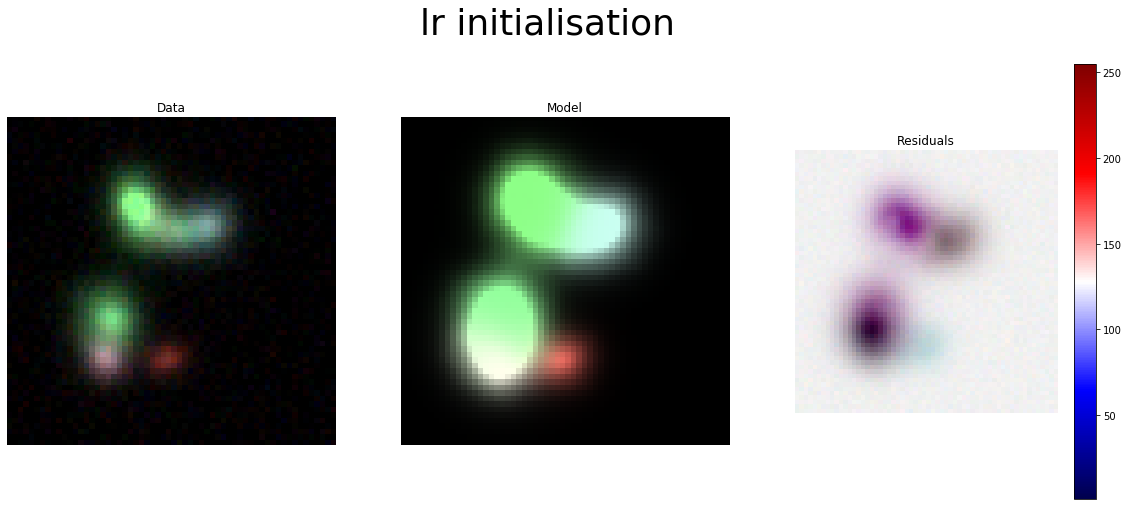

In [11]:
# Building a detection coadd
coadd, bg_cutoff = build_initialization_coadd(obs_lr)

# Source initialisation
lr_sources = [
    scarlet.ExtendedSource(lr_frame, sky_lr, obs_lr)
    for sky_lr in ra_dec_lr
]

blend_lr = scarlet.Blend(lr_sources, obs_lr)
display_init(blend_lr, obs_lr, lr, 0, img_rgb, 'lr initialisation')

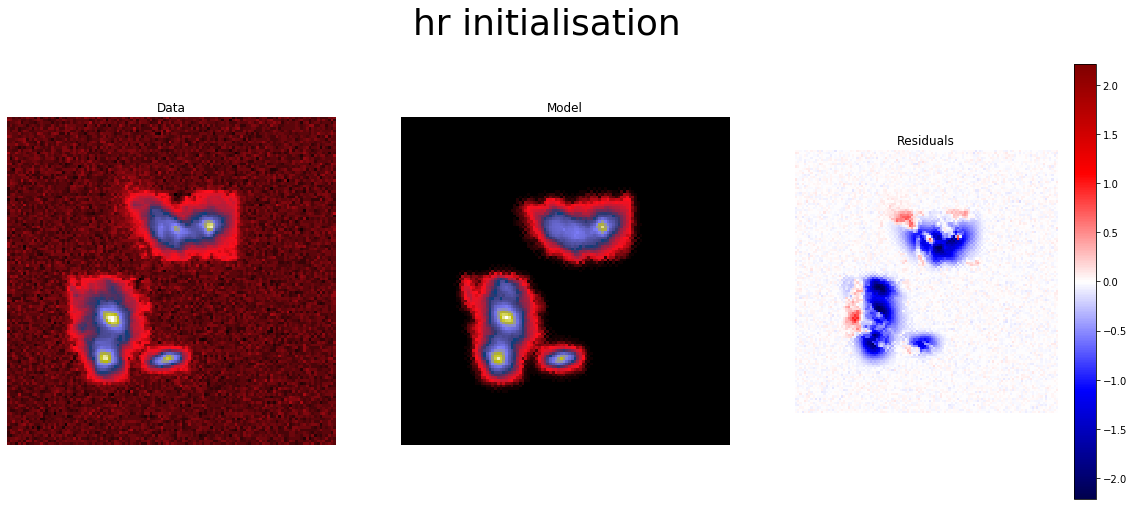

In [12]:
# Building a detection coadd
coadd, bg_cutoff = build_initialization_coadd(obs_hr)
# Source initialisation
hr_sources = [
    scarlet.ExtendedSource(hr_frame, sky_hr, obs_hr)
    for sky_hr in ra_dec_hr
]

blend_hr = scarlet.Blend(hr_sources, obs_hr)
display_init(blend_hr, obs_hr, hr, 1, hr[0], 'hr initialisation')

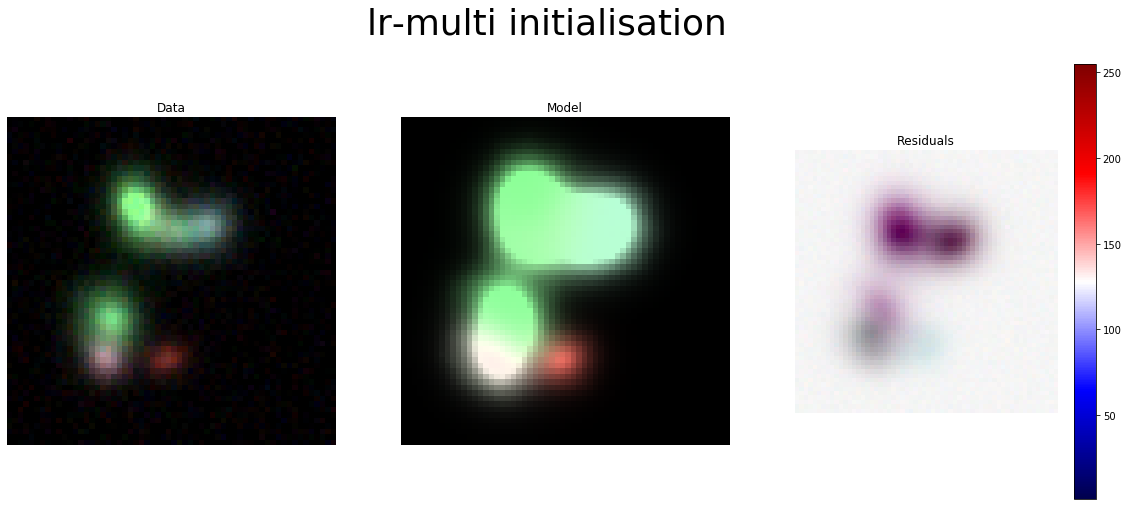

In [13]:
# Building a detection coadd
coadd, bg_cutoff = build_initialization_coadd(obs_lr)

# Source initialisation
lr_sources = [
    scarlet.ExtendedSource(lr_frame, sky_multi, obs_lr)
    for sky_multi in ra_dec_multi
]

blend_multilr = scarlet.Blend(lr_sources, obs_lr)
display_init(blend_multilr, obs_lr, lr, 2, img_rgb, 'lr-multi initialisation')

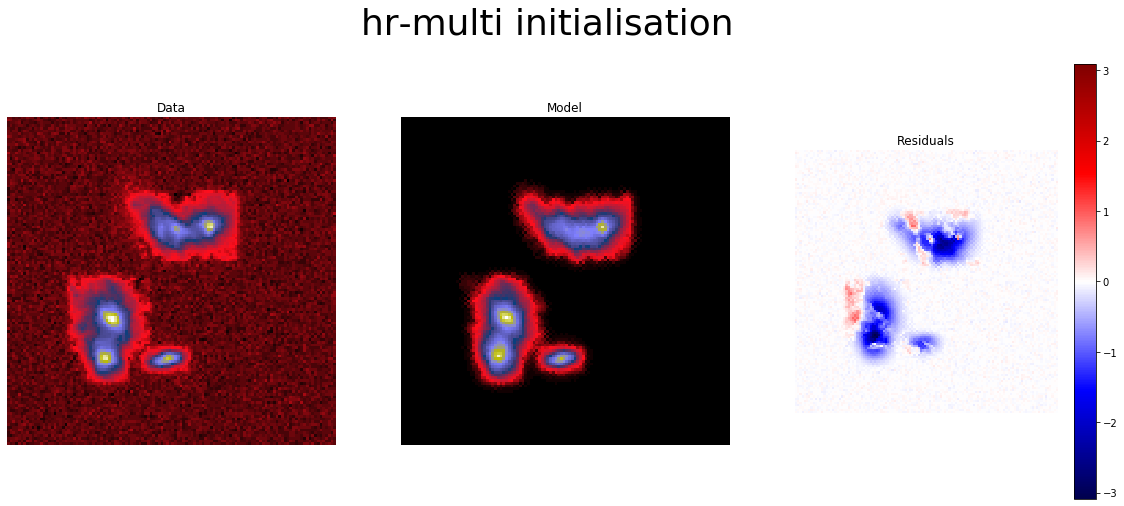

In [14]:
# Building a detection coadd
coadd, bg_cutoff = build_initialization_coadd(obs_hr)

# Source initialisation
hr_sources = [
    scarlet.ExtendedSource(hr_frame, sky_multi, obs_hr)
    for sky_multi in ra_dec_multi
]

blend_multihr = scarlet.Blend(hr_sources, obs_hr)
display_init(blend_multihr, obs_hr, hr, 3, hr[0], 'hr-multi initialisation')

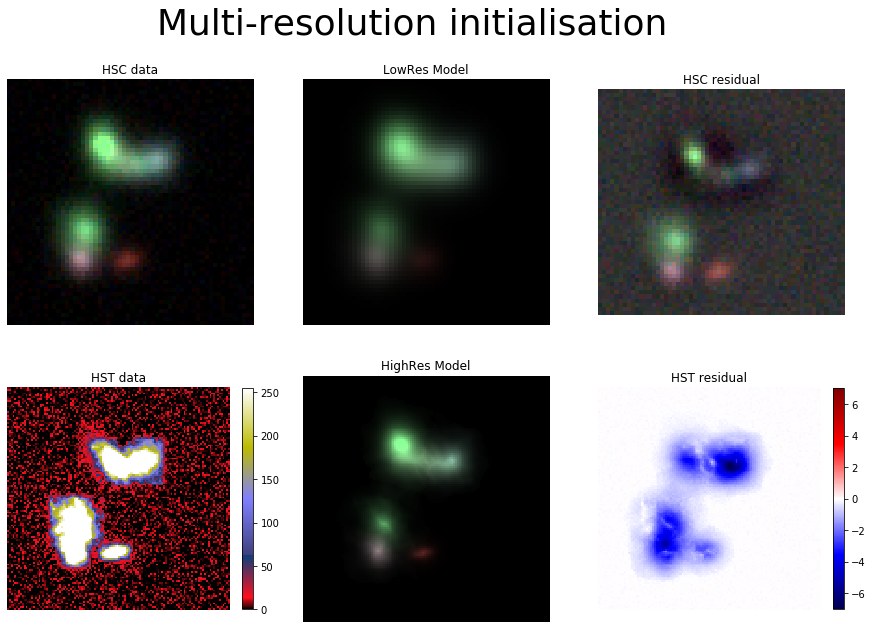

In [15]:
# Load the model and calculate the residual
model_multi = blend_multi.get_model()

model_lr = multi_lr.render(model_multi)
init_rgb = scarlet.display.img_to_rgb(model_multi[:-1], norm=lr_norm)
init_rgb_lr = scarlet.display.img_to_rgb(model_lr, norm=lr_norm)
residual_lr = lr - model_lr
# Trim the bottom source not part of the blend from the image
residual_lr_rgb = scarlet.display.img_to_rgb(residual_lr[:,:-5])

# Get the HR residual
residual_hr = (hr - multi_hr.render(model_multi))[0]
vmax = np.abs(residual_hr).max()

plt.figure(figsize=(15, 10))

plt.subplot(231)
plt.suptitle('Multi-resolution initialisation', fontsize=36)
plt.imshow(img_rgb)
plt.axis('off')
plt.title("HSC data")
plt.subplot(235)
plt.imshow(init_rgb)
plt.axis('off')
plt.title("HighRes Model")
plt.subplot(232)
plt.imshow(init_rgb_lr)
plt.axis('off')
plt.title("LowRes Model")
plt.subplot(236)
plt.imshow(residual_hr, cmap="seismic", vmin=-vmax, vmax=vmax)
plt.axis('off')
plt.colorbar(fraction=.045)
plt.title("HST residual")
plt.subplot(233)
plt.imshow(residual_lr_rgb)
plt.axis('off')
plt.title("HSC residual")
plt.subplot(234)
plt.imshow(hr_img[:,:,0])
plt.axis('off')
plt.colorbar(fraction=.045)
plt.title('HST data')
plt.show()

scarlet ran for 300 iterations to logL = 23124.97885765068


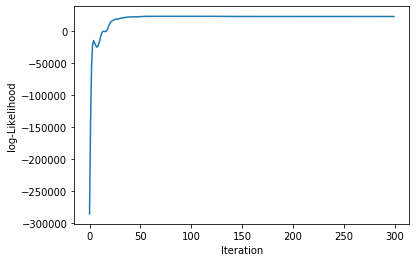

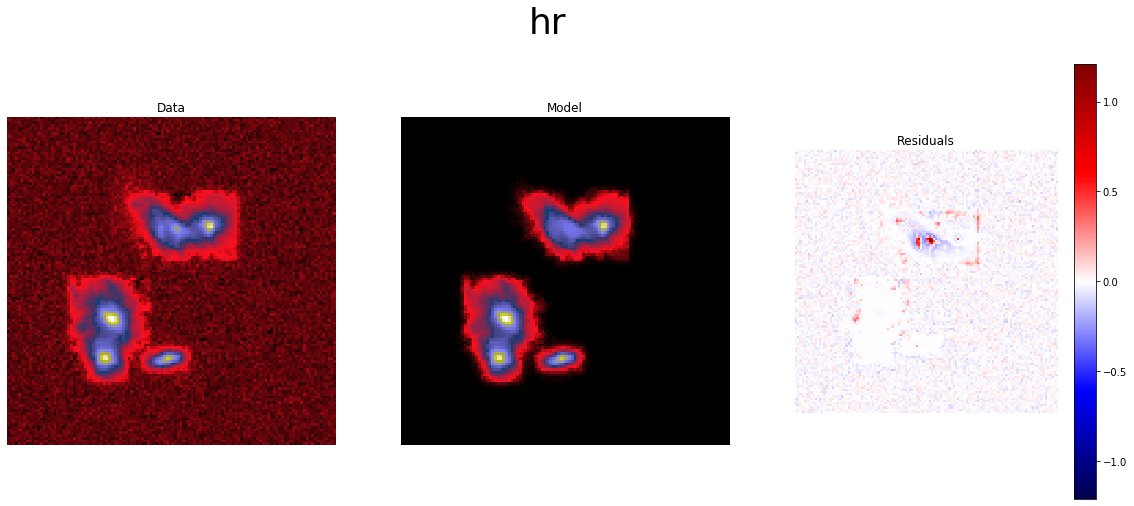

In [16]:
blend_hr.fit(300, e_rel = 1.e-7)
print("scarlet ran for {0} iterations to logL = {1}".format(len(blend_hr.loss), -blend_hr.loss[-1]))
plt.plot(-np.array(blend_hr.loss))
plt.xlabel('Iteration')
plt.ylabel('log-Likelihood')
display_init(blend_hr, obs_hr, hr, 0, hr[0], 'hr')

scarlet ran for 300 iterations to logL = 25254.4078957553


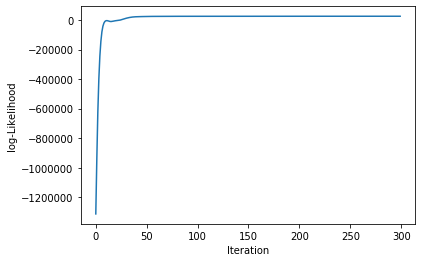

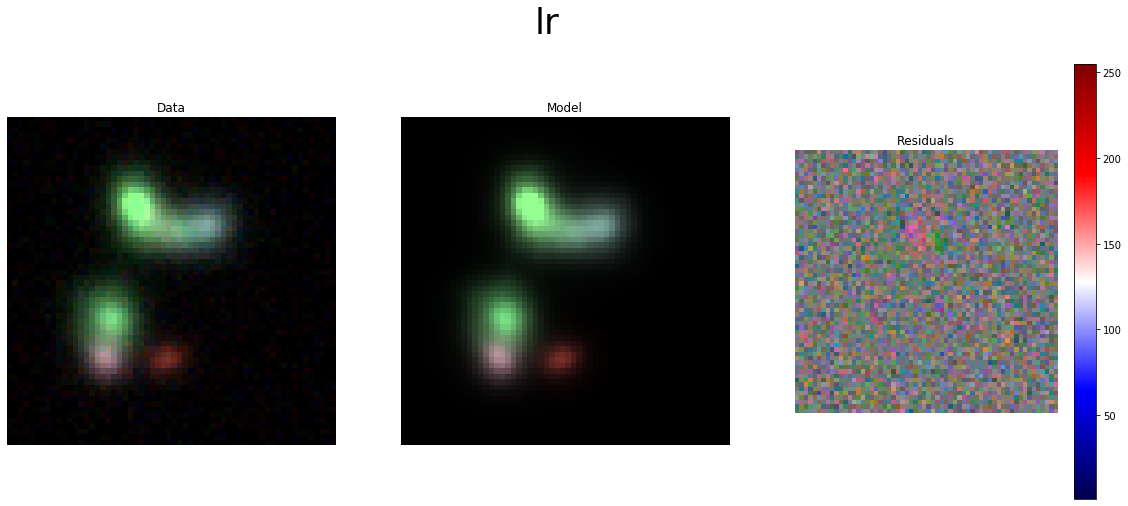

In [17]:
blend_lr.fit(300, e_rel = 1.e-7)
print("scarlet ran for {0} iterations to logL = {1}".format(len(blend_lr.loss), -blend_lr.loss[-1]))
plt.plot(-np.array(blend_lr.loss))
plt.xlabel('Iteration')
plt.ylabel('log-Likelihood')
display_init(blend_lr, obs_lr, lr, 0, img_rgb, 'lr')

scarlet ran for 300 iterations to logL = 24473.375562382756


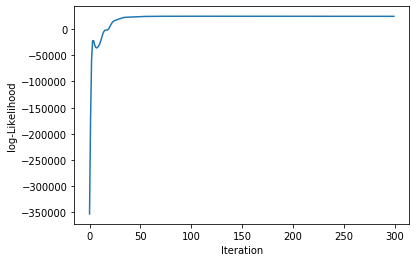

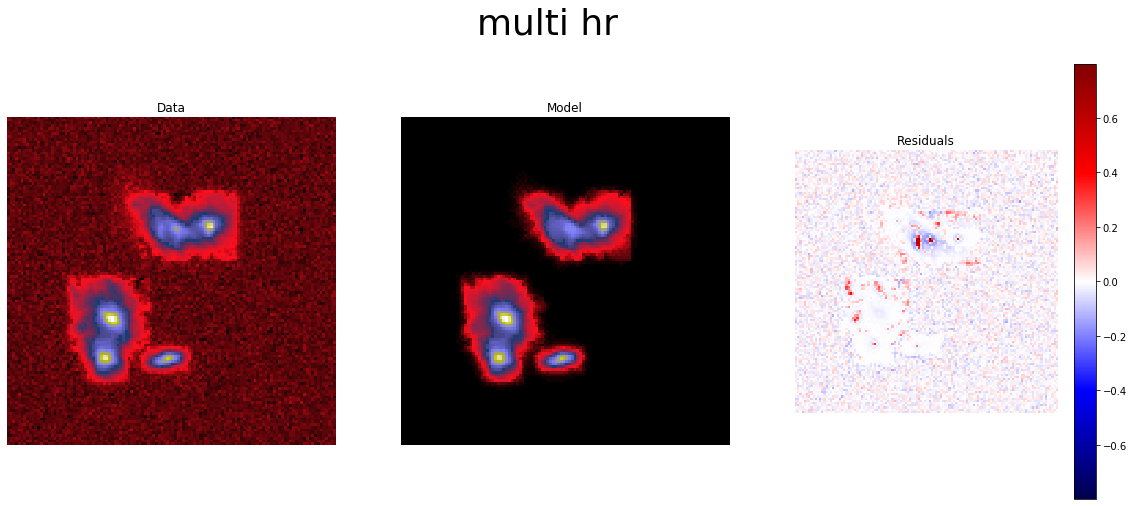

In [18]:
blend_multihr.fit(300, e_rel = 1.e-10)
print("scarlet ran for {0} iterations to logL = {1}".format(len(blend_multihr.loss), -blend_multihr.loss[-1]))
plt.plot(-np.array(blend_multihr.loss))
plt.xlabel('Iteration')
plt.ylabel('log-Likelihood')
display_init(blend_multihr, obs_hr, hr, 3, hr[0], 'multi hr')

scarlet ran for 300 iterations to logL = 25264.677382441987


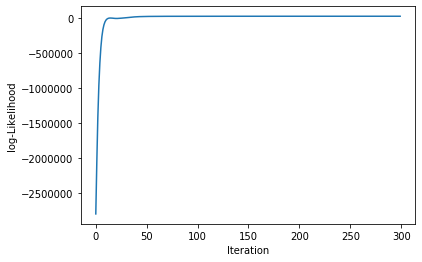

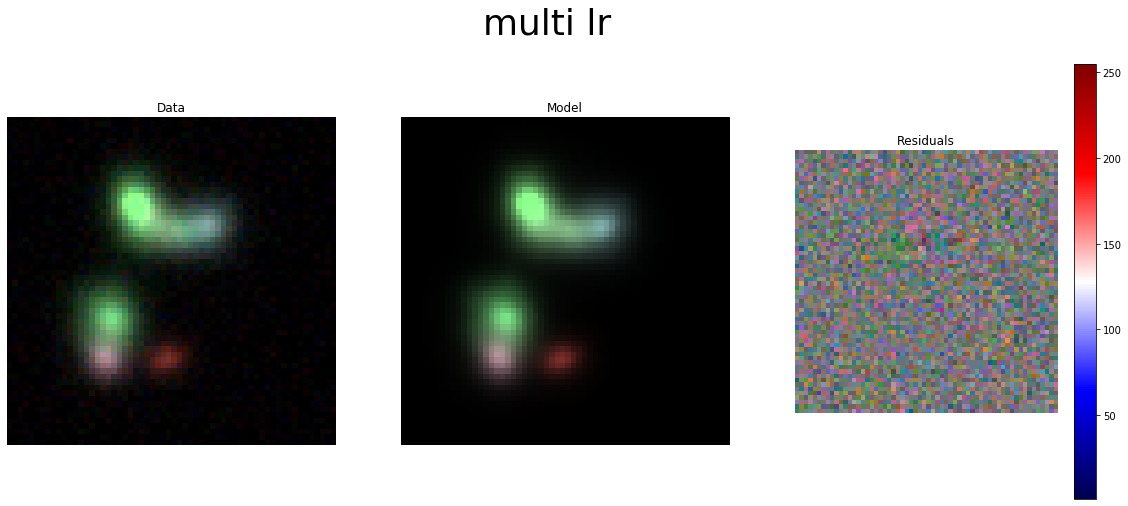

In [19]:
blend_multilr.fit(300, e_rel = 1.e-7)
print("scarlet ran for {0} iterations to logL = {1}".format(len(blend_multilr.loss), -blend_multilr.loss[-1]))
plt.plot(-np.array(blend_multilr.loss))
plt.xlabel('Iteration')
plt.ylabel('log-Likelihood')
display_init(blend_multilr, obs_lr, lr, 2, img_rgb, 'multi lr')

CPU times: user 13min 59s, sys: 3min 10s, total: 17min 10s
Wall time: 7min 19s
scarlet ran for 300 iterations to logL = 49658.32456826915


Text(0, 0.5, 'log-Likelihood')

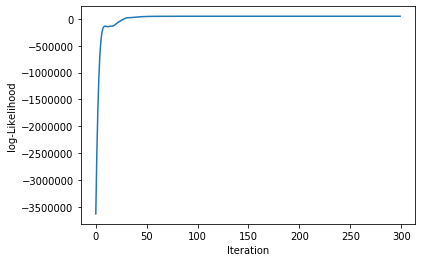

In [20]:
%time blend_multi.fit(300, e_rel = 1.e-10)
print("scarlet ran for {0} iterations to logL = {1}".format(len(blend_multi.loss), -blend_multi.loss[-1]))
plt.plot(-np.array(blend_multi.loss))
plt.xlabel('Iteration')
plt.ylabel('log-Likelihood')

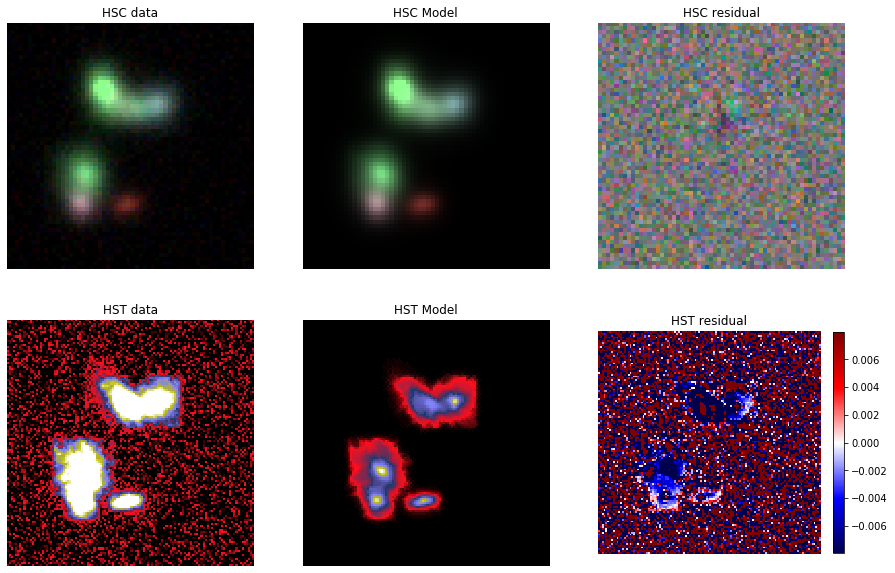

In [21]:
model_multi = blend_multi.get_model()
model_hr = multi_hr.render(model_multi)
model_lr = multi_lr.render(model_multi)


lrhr_norm = AsinhMapping(minimum=0, stretch=1, Q=5)
rgb = scarlet.display.img_to_rgb(model_multi[:-1], norm=lrhr_norm)
rgb_lr = scarlet.display.img_to_rgb(model_lr, norm=lr_norm)
residual_lr = lr - model_lr

# Trim the bottom source not part of the blend from the image
residual_lr_rgb = scarlet.display.img_to_rgb(residual_lr[:,:])

# Get the HR residual
residual_hr = (hr - model_hr)[0]
vmax = np.abs(residual_hr).max()/100

plt.figure(figsize=(15, 10))
plt.subplot(231)
plt.imshow(img_rgb)
plt.axis('off')
plt.title("HSC data")
plt.subplot(235)
plt.imshow(model_hr[0])
plt.axis('off')
plt.title("HST Model")
plt.subplot(232)
plt.imshow(rgb_lr)
plt.axis('off')
plt.title("HSC Model")
plt.subplot(236)
plt.imshow(residual_hr, cmap="seismic", vmin = -vmax, vmax = vmax)
plt.axis('off')
plt.colorbar(fraction=.045)
plt.title("HST residual")
plt.subplot(233)
plt.imshow(residual_lr_rgb)
plt.axis('off')
plt.title("HSC residual")
plt.subplot(234)
plt.imshow(hr_img[:,:,0])
plt.axis('off')
plt.title('HST data')
plt.show()

source number  0


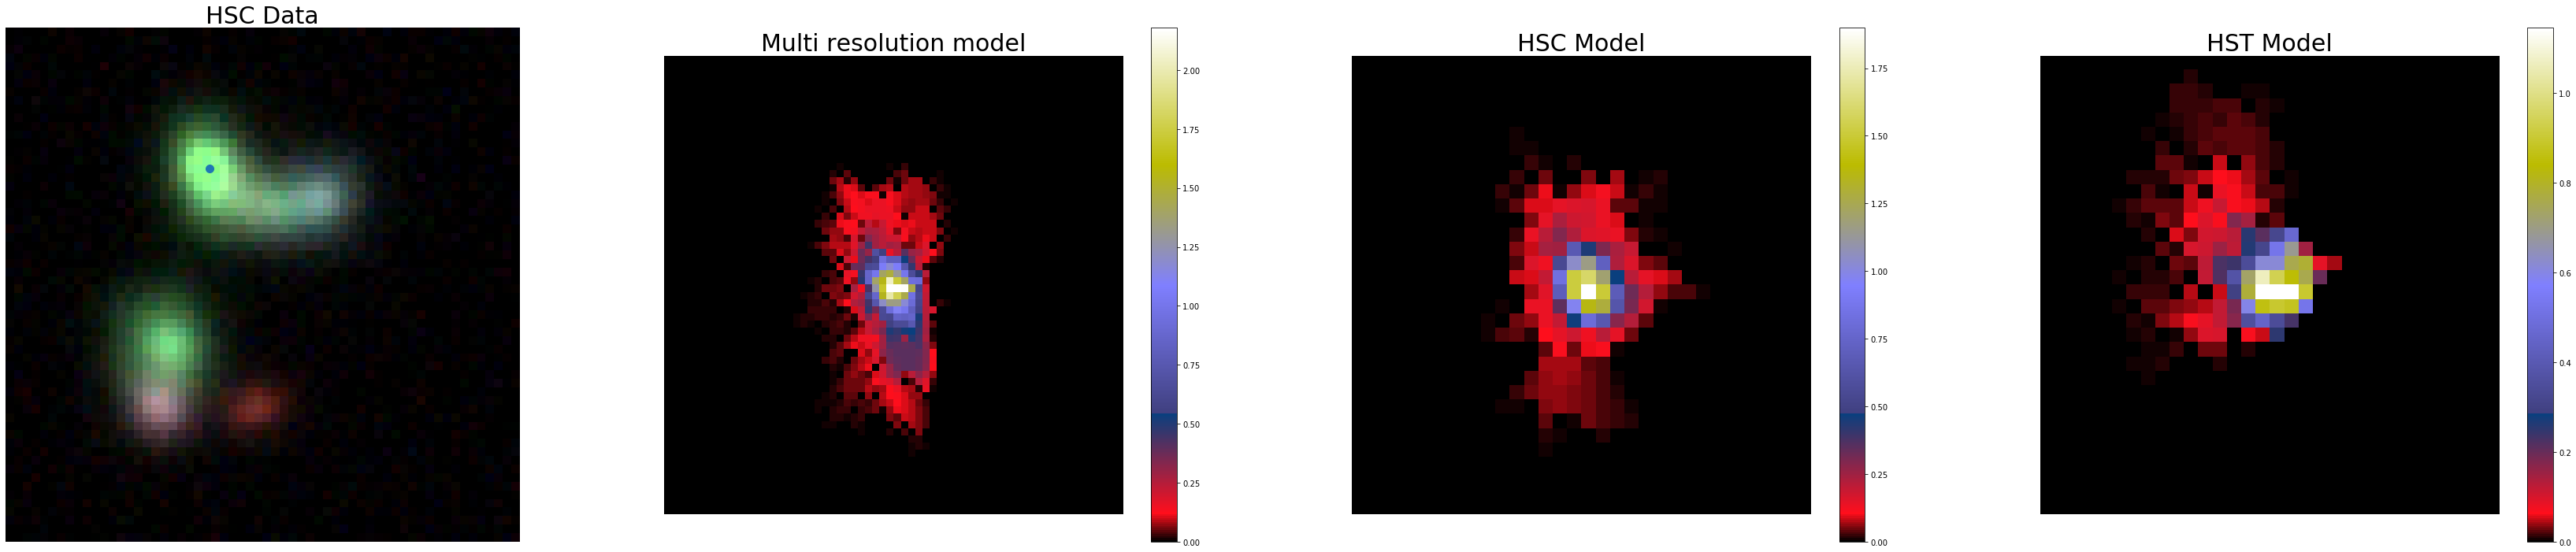

source number  1


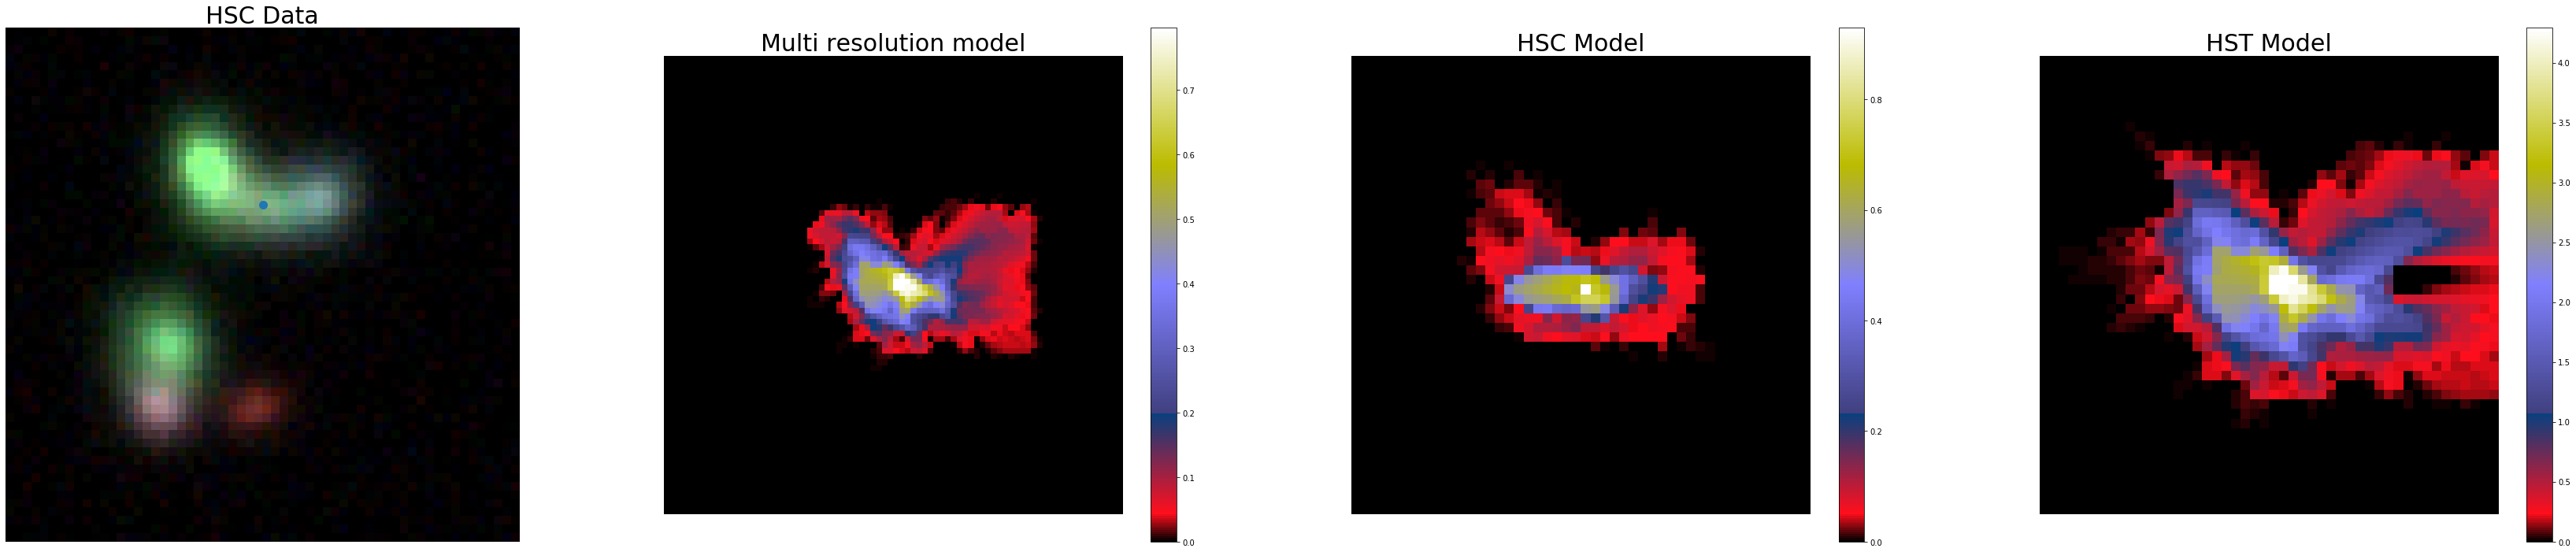

source number  2


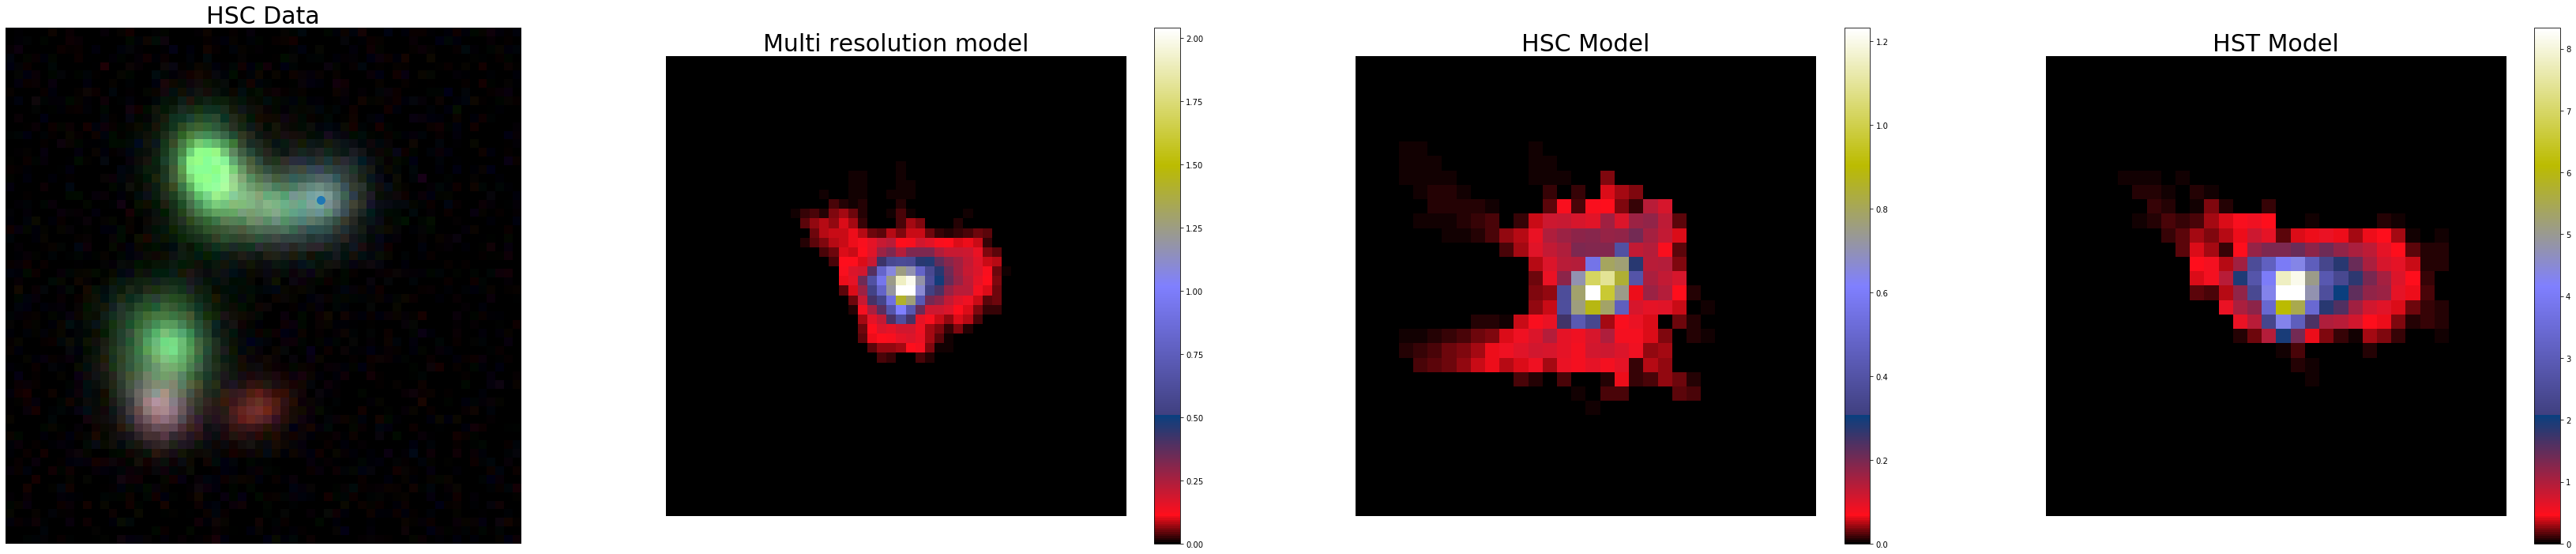

source number  3


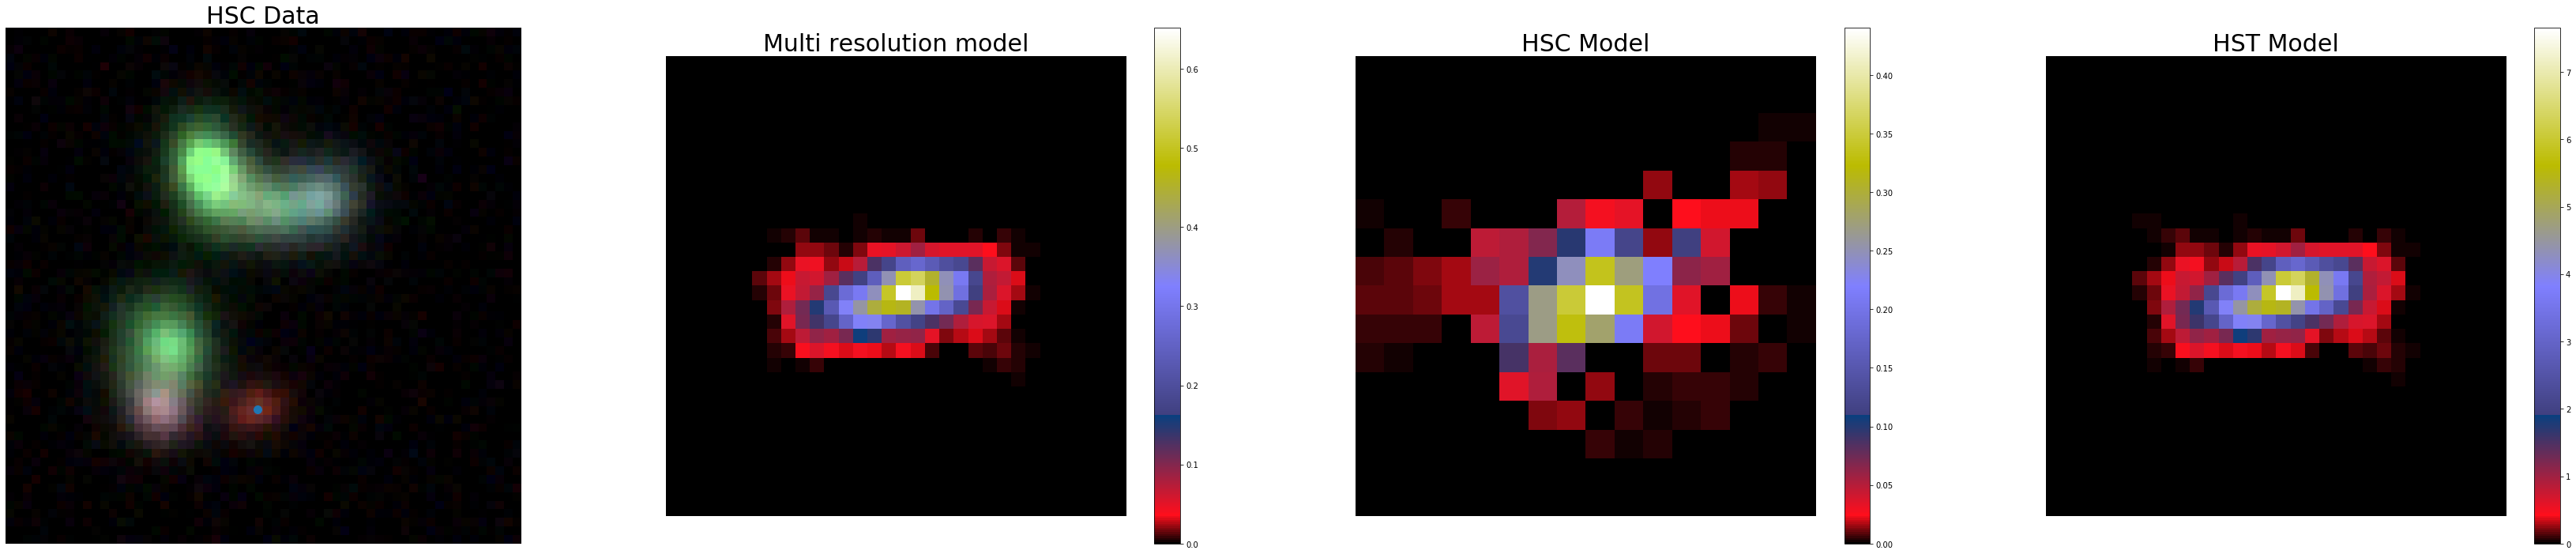

source number  4


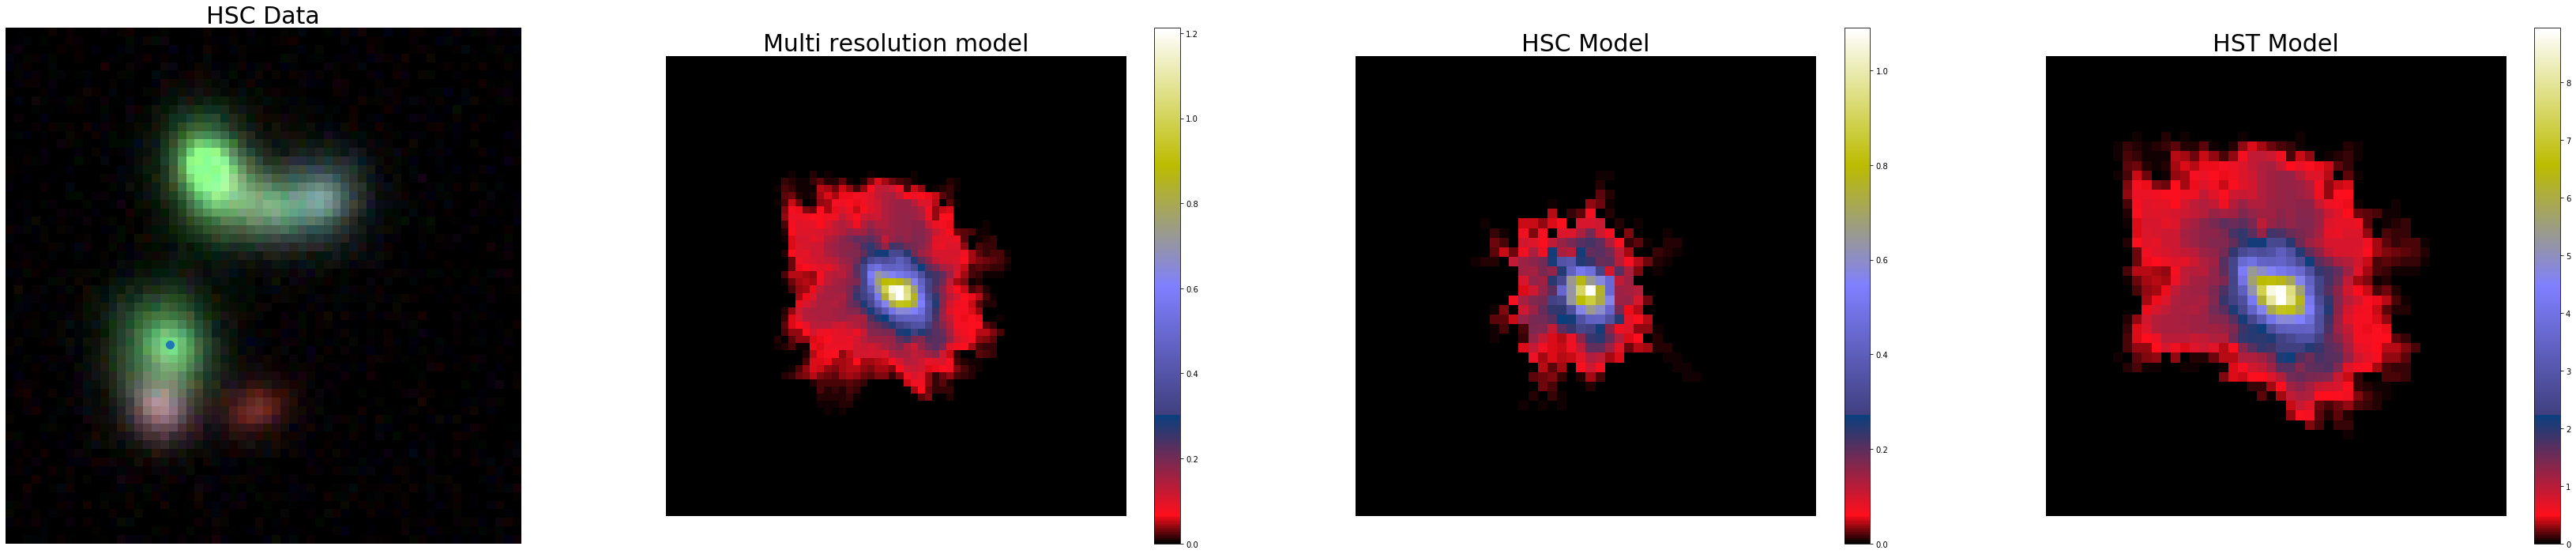

source number  5


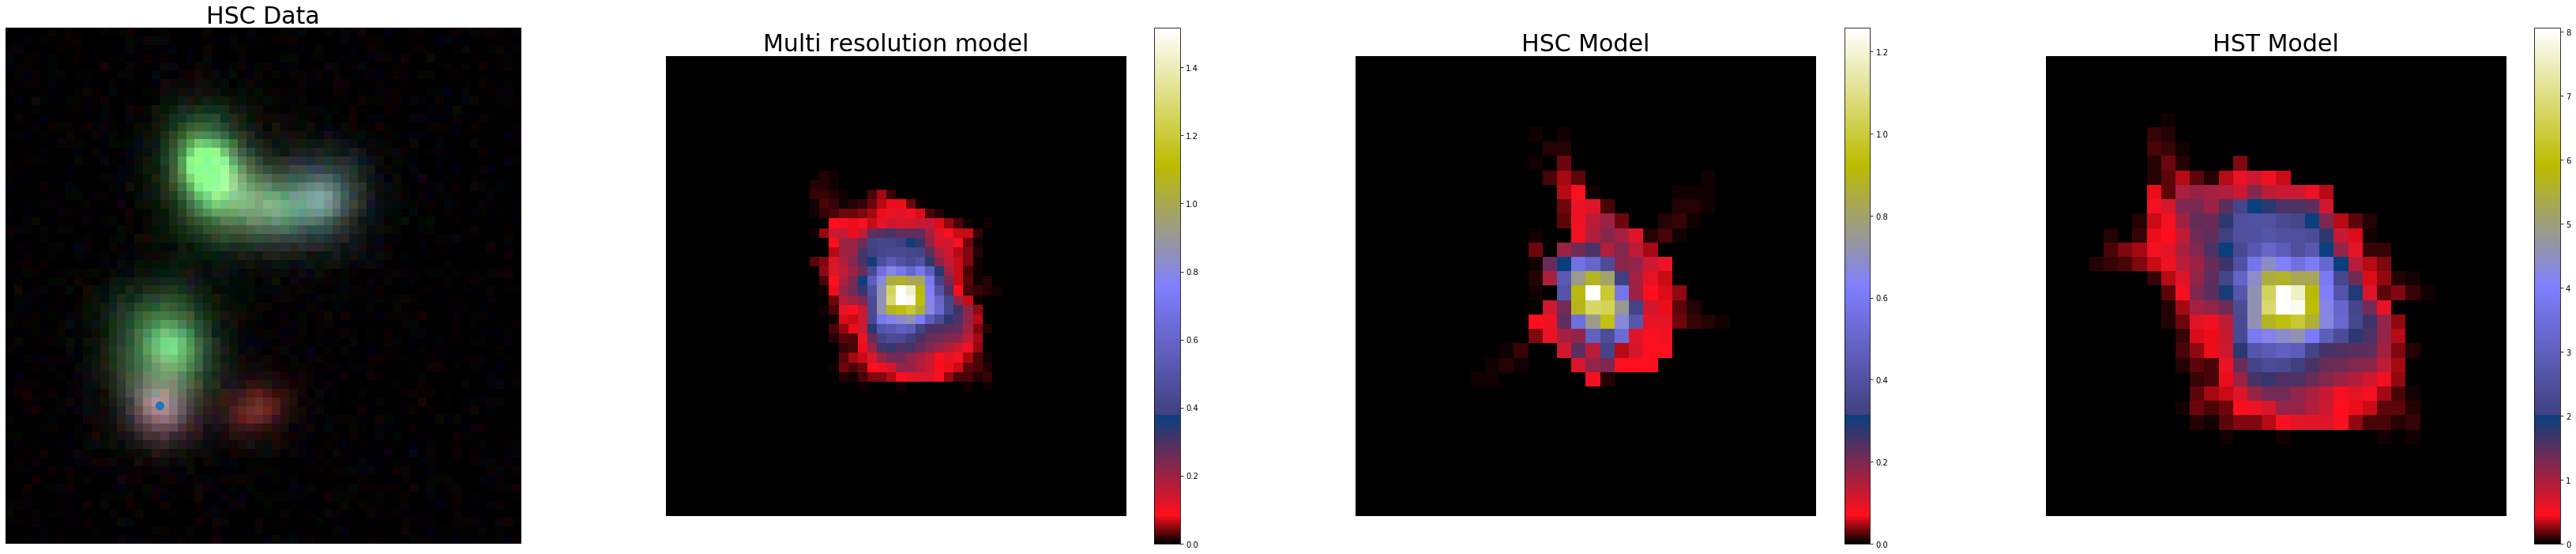

In [22]:
has_truth = False
axes = 2

lr_norm = AsinhMapping(minimum=0, stretch=.00000001, Q=100)
for k,src in enumerate(blend_multi.sources):
    print('source number ', k)
    # Get the model for a single source
    source_multi = src.get_model()
    source_multilr = blend_multilr[k].get_model()
    source_multihr = blend_multihr[k].get_model()
    
    # Display the low resolution image and residuals
    img_lr_rgb = scarlet.display.img_to_rgb(model_lr, norm = lr_norm)
    
    plt.figure(figsize=(60,12))
    
    plt.subplot(141)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.plot(Xm[k],Ym[k], 'o', markersize = 10)
    plt.title("HSC Data", fontsize = 30)
    plt.subplot(142)
    plt.imshow(source_multi[0])
    plt.axis('off')
    plt.colorbar()
    plt.title("Multi resolution model", fontsize = 30)
    plt.subplot(143)
    plt.imshow(source_multilr[0])
    plt.axis('off')
    plt.colorbar()
    plt.title("HSC Model", fontsize = 30)
    plt.subplot(144)
    plt.imshow(source_multihr[-1])
    plt.axis('off')
    plt.colorbar()
    plt.title("HST Model", fontsize = 30)
    plt.show()

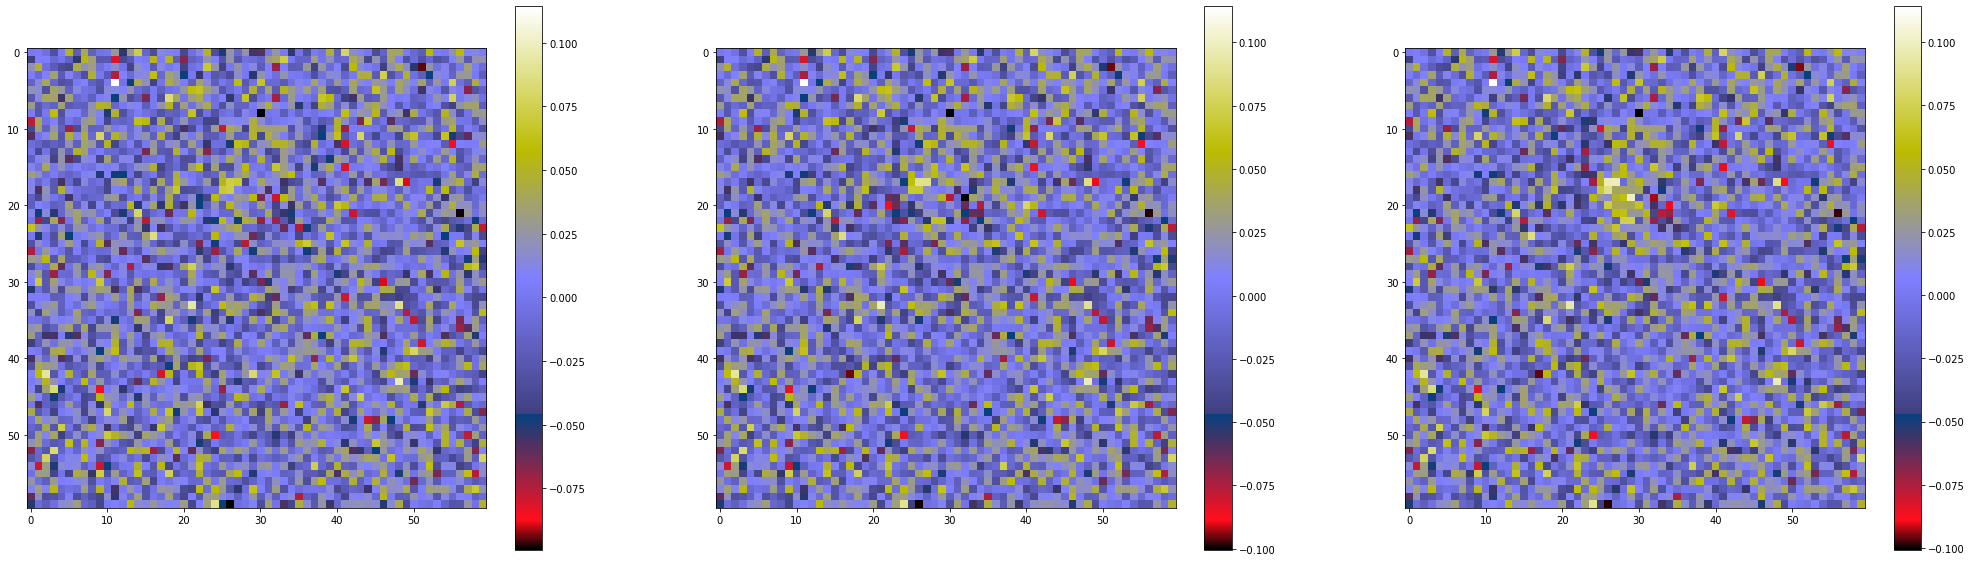

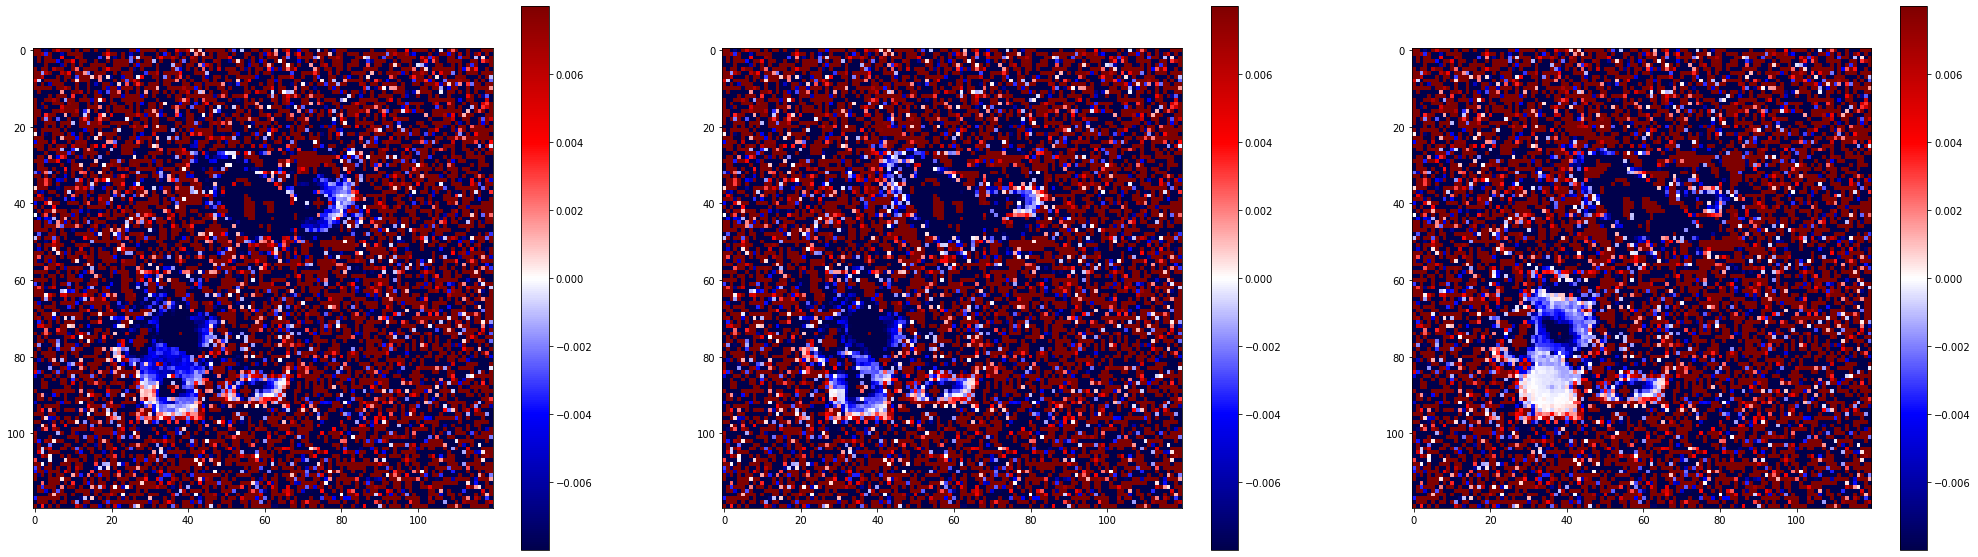

In [23]:
# Results:
model_ = blend_multi.get_model()
mod = []
[mod.append(Starlet(m).filter()) for m in model_multi]
model_multi = np.array(mod)[:,0,:,:]

render_hrm = multi_hr.render(model_multi)
render_lrm = multi_lr.render(model_multi)

model_lr = blend_lr.get_model()
render_lr = obs_lr.render(model_lr)

model_hr = blend_hr.get_model()
render_hr = obs_hr.render(model_hr)

model_lrmulti = blend_multilr.get_model()
render_lrmulti = obs_lr.render(model_lrmulti)

model_hrmulti = blend_multihr.get_model()
render_hrmulti = obs_hr.render(model_hrmulti)

# RGB images of the residuals
plt.figure(figsize = (35,10))
plt.subplot(131)
plt.imshow((lr - render_lrm)[2])
plt.colorbar()
plt.subplot(132)
plt.imshow((lr - render_lrmulti)[2])
plt.colorbar()
plt.subplot(133)
plt.imshow((lr - render_lr)[2])
plt.colorbar()
plt.show()

# RGB images of the residuals
plt.figure(figsize = (35,10))
plt.subplot(131)
plt.imshow((hr - render_hrm)[0], cmap="seismic", vmin = -vmax, vmax = vmax)
plt.colorbar()
plt.subplot(132)
plt.imshow((hr - render_hrmulti)[0], cmap="seismic", vmin = -vmax, vmax = vmax)
plt.colorbar()
plt.subplot(133)
plt.imshow((hr - render_hr)[0], cmap="seismic", vmin = -vmax, vmax = vmax)
plt.colorbar()
plt.show()




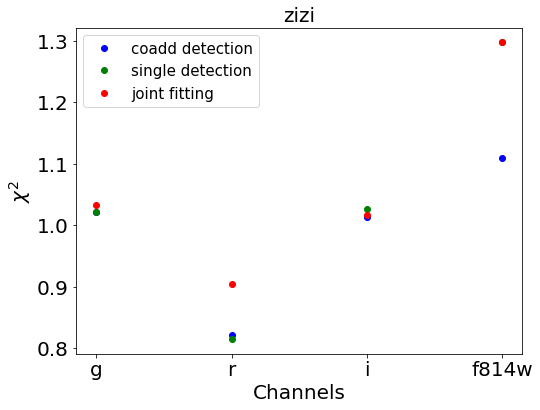

In [24]:
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
# HSC residuals
chi_joint =  3./lr.size*(np.sum((lr - render_lrm)**2, axis = (-2,-1))/mad_wavelet(lr)**2)
chi_multi = 3./lr.size*(np.sum((lr - render_lrmulti)**2, axis = (-2,-1))/mad_wavelet(lr)**2)
chi_alone = 3./lr.size*(np.sum((lr - render_lr)**2, axis = (-2,-1))/mad_wavelet(lr)**2)

chi_hr = 1./hr.size*np.sum((hr - render_hrm)[0]**2/mad_wavelet(hr)**2)
chi_hrmulti = 1./hr.size*np.sum((hr - render_hrmulti)**2/mad_wavelet(hr)**2)
chi_hr = 1./hr.size*np.sum((hr - render_hr)**2/mad_wavelet(hr)**2)

plt.figure(figsize=(8,6))
plt.title('zizi', fontsize = 20)

plt.plot(['g','r','i'], chi_multi, 'ob', label = 'coadd detection')
plt.plot(['g','r','i'], chi_alone, 'og', label = 'single detection')
plt.plot(['g','r','i'], chi_joint, 'or', label = 'joint fitting')

plt.plot(['f814w'], chi_hrmulti, 'ob')
plt.plot(['f814w'], chi_hr, 'og')
plt.plot(['f814w'], chi_hr, 'or')

plt.ylabel('$\chi^2$', fontsize = 20)
plt.xlabel('Channels', fontsize = 20)
plt.legend(fontsize = 15)
plt.savefig('chi_0.png')
plt.show()
